In [1]:
import os
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
from sklearn.model_selection import train_test_split
from monai.config import print_config
from monai.data import DataLoader, Dataset, ArrayDataset, CacheDataset
from monai.data.utils import pad_list_data_collate, decollate_batch
from monai.handlers.utils import from_engine
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, TverskyLoss,DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations, AsDiscrete, Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped,
    Transform, AsDiscreted, CropForegroundd,RandGaussianNoised,RandScaleIntensityd,
    NormalizeIntensityd, ResizeD,  ToTensord, ScaleIntensityRanged, Orientationd,
     Spacingd, ToDeviced,RandGaussianNoised,RandShiftIntensityd
)
import glob
import math
from monai.utils import set_determinism

In [2]:
# Set the data directory path
data_dir = "/home/Task07_Pancreas/"


# Get the file paths of the training images and labels
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))

# Create a list of dictionaries, each containing an image-label pair
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

# Split the data into validation and training sets
val_files, train_files = data_dicts[:25], data_dicts[25:]

In [3]:
class GettheDesiredLabels(Transform):
    def __call__(self, data):
        # Extract the label from the input data
        label = data["label"]

        # Keep only the second and third channels from the label
        single_label = label[1:3]

        # Replace the original label with the modified label
        data["label"] = single_label

        # Return the modified data
        return data

In [4]:
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),  # Load the image and label data from file
    EnsureChannelFirstd(keys=["image", "label"]),  # Ensure the channel dimension is the first dimension
    ToDeviced(keys=["image", "label"], device="cuda:1"),  # Move the data to the specified device (commented out)
    AsDiscreted(keys='label', to_onehot=3),  # Convert the label to one-hot encoding with 3 channels
    GettheDesiredLabels(),  # Extract the desired channels from the label
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-57,
        a_max=164,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),  # Rescale the intensity values of the image within the specified range
    CropForegroundd(keys=["image", "label"], source_key="image"),  # Crop the image and label to remove the background
    Orientationd(keys=["image", "label"], axcodes="RAS"),  # Adjust the image and label orientation to RAS
    Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),  # Adjust the spacing of the image and label
    ResizeD(keys=["image", "label"], spatial_size=[224, 224, 144], mode=("trilinear", "nearest")),  # Resize the image and label to the specified spatial size
    NormalizeIntensityd(keys=["image"]),  # Normalize intensity values of the image
    RandScaleIntensityd(keys=["image"], factors=0.1),  # Apply random scaling of intensity values to the image
    RandShiftIntensityd(keys=["image"], offsets=0.1),  # Apply random shifting of intensity values to the image
    RandGaussianNoised(keys=["image"], std=0.1),  # Add random Gaussian noise to the image
    ToTensord(keys=["image", "label"]),  # Convert the image and label to PyTorch tensors
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),  # Load the image and label data from file
    EnsureChannelFirstd(keys=["image", "label"]),  # Ensure the channel dimension is the first dimension
    AsDiscreted(keys='label', to_onehot=3),  # Convert the label to one-hot encoding with 3 channels
    GettheDesiredLabels(),  # Extract the desired channels from the label
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-57,
        a_max=164,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),  # Rescale the intensity values of the image within the specified range
    CropForegroundd(keys=["image", "label"], source_key="image"),  # Crop the image and label to remove the background
    Orientationd(keys=["image", "label"], axcodes="RAS"),  # Adjust the image and label orientation to RAS
    Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),  # Adjust the spacing of the image and label
    ResizeD(keys=["image", "label"], spatial_size=[224, 224, 144], mode=("trilinear", "nearest")),  # Resize the image and label to the specified spatial size
    ToTensord(keys=["image", "label"]),  # Convert the image and label to PyTorch tensors
])


In [5]:
train_dataset = CacheDataset(data=train_files, transform=train_transforms)  # Create a dataset for training with the training files and specified transformations
val_dataset = CacheDataset(data=val_files, transform=val_transforms)  # Create a dataset for validation with the validation files and specified transformations

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=1, collate_fn=pad_list_data_collate)  # Create a data loader for training with the training dataset
val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=pad_list_data_collate)  # Create a data loader for validation with the validation dataset


Loading dataset: 100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


In [6]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 256
Number of validation samples: 25


In [7]:
sample_index = 0  # Specify the index of the sample to check
sample = train_dataset[sample_index]  # Retrieve the sample at the specified index from the training dataset
binarized_label = sample['label']  # Access the binarized label data from the sample
unique_values = torch.unique(binarized_label)  # Find the unique values in the binarized label
count = len(unique_values)  # Count the number of unique values
print(f"Number of unique values: {count}")  # Print the count of unique values


Number of unique values: 2


In [8]:
# Get the first sample in the dataset
first_sample = train_dataset[0]


image_shape = first_sample['image'].shape
label_shape = first_sample['label'].shape

print(f"Image shape: {image_shape}")
print(f"Label shape: {label_shape}")

Image shape: torch.Size([1, 224, 224, 144])
Label shape: torch.Size([2, 224, 224, 144])


72


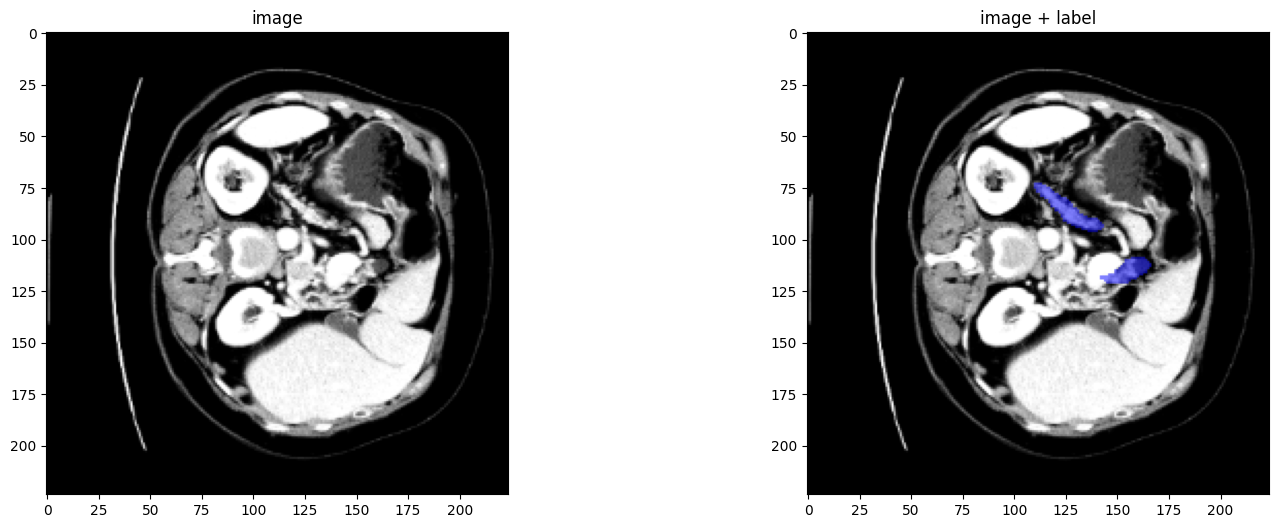

72


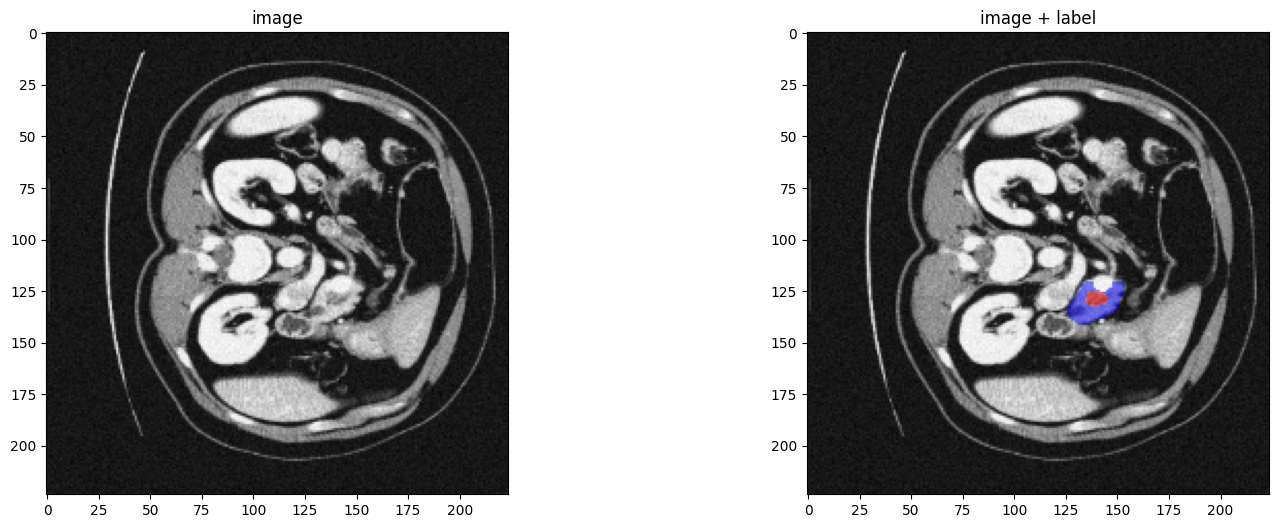

In [9]:
# Create a colormap for the blue label
colors = [(0, 0, 1, i) for i in np.linspace(0, 1, 100)]
blue_cmap = mcolors.LinearSegmentedColormap.from_list('blue_alpha', colors)

# Create a colormap for the red label
colors = [(1, 0, 0, i) for i in np.linspace(0, 1, 100)]
red_cmap = mcolors.LinearSegmentedColormap.from_list('red_alpha', colors)

# Loop over samples in the dataset
for i in range(1, 3):
    val_data_example = train_dataset[i]

    # Select a slice to visualize (e.g., the middle slice)
    slice_idx = val_data_example['image'].shape[3] // 2  # Adjust to the depth dimension
    print(slice_idx)

    # Get image and labels
    image = val_data_example['image'][0, :, :, slice_idx].detach().cpu()
    label3 = val_data_example['label'][1, :, :, slice_idx].detach().cpu()
    label2 = val_data_example['label'][0, :, :, slice_idx].detach().cpu()

    # Create a figure
    plt.figure(figsize=(18, 6))

    # Plot the image
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap='gray')

    # Overlay the labels on the image
    plt.subplot(1, 2, 2)
    plt.title("image + label")
    plt.imshow(image, cmap='gray')
    plt.imshow(label2, cmap=blue_cmap, alpha=0.5)  # Use alpha for transparency
    plt.imshow(label3, cmap=red_cmap, alpha=0.5)

    # Show the plot
    plt.show()


In [33]:
# Define your UNet model as a function
def segresnet(in_channels, out_channels):
    """

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.

    Returns:
        SegResNet: UNet model based on the SegResNet architecture.
    """

    # Create a SegResNet model with the specified parameters
    model = SegResNet(
        blocks_down=[1, 2, 2, 4],  # Number of residual blocks in each downsampling path
        blocks_up=[1, 1, 1],  # Number of residual blocks in each upsampling path
        init_filters=16,  # Number of filters in the first layer
        in_channels=in_channels,  # Number of input channels
        out_channels=out_channels,  # Number of output channels
        dropout_prob=0.2,  # Dropout probability
    )

    return model


In [34]:
device = torch.device('cuda:1')  # Specify the device to be used (e.g., 'cuda:0' for the first GPU)

device_ids = [1]  # Specify the GPU device IDs to be used

# Print the number of GPUs being used
num_gpus = len(device_ids)
print("Using", num_gpus, "GPUs!")

Using 1 GPUs!


In [35]:

in_channels = 1  # Number of input channels
out_channels = 2  # Number of output channels
model = segresnet(in_channels, out_channels)  
model = model.to(device)  # Move the model to the specified device (GPU)
if torch.cuda.device_count() > 1:
    print("Using", num_gpus, "GPUs!")
    model = nn.DataParallel(model, device_ids=device_ids)


Using 1 GPUs!


In [36]:
# class HandleOverlap(Transform):
#     def __call__(self, pred):
#         # Find the overlapping pixels (those belong to both classes)
#         overlap = (pred[0] > 0.5) & (pred[1] > 0.5)

#         # Assign the overlapping pixels to the class with higher prediction probability
#         class_0_overlap = pred[0] > pred[1]
#         class_1_overlap = pred[1] >= pred[0]

#         pred[0][overlap & class_0_overlap] = 1
#         pred[1][overlap & class_1_overlap] = 1

#         pred[0][overlap & class_1_overlap] = 0
#         pred[1][overlap & class_0_overlap] = 0

#         # Return the modified prediction
#         return pred


In [37]:
val_interval = 1
VAL_AMP = True
max_epochs=200
# loss_function = DiceLoss(class_weights=[weight_class1, weight_class2],smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

# loss_function = TverskyLoss(
#     to_onehot_y=False,
#     sigmoid=True,
#     softmax=False,
#     alpha=0.5,
#     beta=0.5,
#     reduction="mean",
#     smooth_nr=0,
#     smooth_dr=1e-05,
#     batch=False
# )
pancreas_weight=1
tumor_weight=4
ce_weights = torch.tensor([pancreas_weight, tumor_weight], device=device)
loss_function = DiceCELoss(ce_weight=ce_weights, smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric( reduction="mean")
dice_metric_batch = DiceMetric( reduction="mean_batch")


post_trans = Compose([
    Activations(sigmoid=True), 
    # HandleOverlap(),  # handle overlap before converting to discrete values
    AsDiscrete(threshold=0.5)
])




In [38]:
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(224, 224, 144),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True

In [39]:
best_metric = -1  # Initialize the best metric value
best_metric_epoch = -1  # Initialize the epoch corresponding to the best metric
best_metrics_epochs_and_time = [[], [], []]  # List to store the best metric, epoch, and time
epoch_loss_values = []  # List to store the loss value for each epoch
metric_values = []  # List to store the metric value for each epoch
metric_values_class1 = []  # List to store the metric value for class 1
metric_values_class2 = []  # List to store the metric value for class 2
model_dir = "/home/model_codes/"  # Directory to save the best metric model
best_metric_class2 = -1  # Initialize the best metric_class2 value
best_metric_class2_epoch = -1 

total_start = time.time()  # Start time for total training

# Iterate over each epoch
for epoch in range(max_epochs):
    epoch_start = time.time()  # Start time for the current epoch

    model.train()  # Set the model in training mode
    epoch_loss = 0  # Initialize the epoch loss
    step = 0  # Initialize the step count

    # Iterate over each batch in the training loader
    for batch_data in train_loader:
        step_start = time.time()  # Start time for the current step
        step += 1

        # Move inputs and labels to the specified device (GPU)
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)

        optimizer.zero_grad()  # Clear the gradients
        with torch.cuda.amp.autocast():
            outputs = model(inputs)  # Forward pass
            loss = loss_function(outputs, labels)  # Compute the loss


        scaler.scale(loss).backward()  # Backward pass with gradient scaling
        scaler.step(optimizer)  # Update the model parameters
        scaler.update()  # Update the gradient scaler
        epoch_loss += loss.item()  # Accumulate the epoch loss

    lr_scheduler.step()  # Update the learning rate scheduler
    epoch_loss /= step  # Compute the average epoch loss
    epoch_loss_values.append(epoch_loss)  # Store the epoch loss
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Perform validation at specified intervals
    if (epoch + 1) % val_interval == 0:
        model.eval()  # Set the model in evaluation mode
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)  # Perform inference on validation data
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                # val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)  # Compute the dice metric
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()  # Compute the aggregate metric value
            metric_values.append(metric)  # Store the metric value
            metric_batch = dice_metric_batch.aggregate()
            metric_class1 = metric_batch[0].item()  # Compute the metric value for class 1
            metric_values_class1.append(metric_class1)  # Store the metric value for class 1
            metric_class2 = metric_batch[1].item()  # Compute the metric value for class 2
            metric_values_class2.append(metric_class2)  # Store the metric value for class 2
            
            dice_metric.reset()  # Reset the dice metric
            dice_metric_batch.reset()

            # Check if the current metric is better than the best metric
            if metric > 0.5 and metric_class2 > best_metric_class2:
                best_metric_class2 = metric_class2  # Update the best metric_class2 value
                best_metric_class2_epoch = epoch + 1  # Update the epoch corresponding to the best metric_class2
                # Save the model only when metric_class2 is highest so far and metric is above 0.5
                torch.save(model, os.path.join(model_dir, "best_metric_model_try1.pth"))  # Save the best model
                print("Saved new best metric model")

            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" class1: {metric_class1:.4f} class2: {metric_class2:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
                f"\nbest mean dice class 2: {best_metric_class2:.4f}"
                f" at epoch: {best_metric_class2_epoch}"
            )

    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")

total_time = time.time() - total_start  # Compute the total training time



epoch 1 average loss: 0.9731
current epoch: 1 current mean dice: 0.1318 class1: 0.2626 class2: 0.0009
best mean dice: -1.0000 at epoch: -1
best mean dice class 2: -1.0000 at epoch: -1
time consuming of epoch 1 is: 85.5766
epoch 2 average loss: 0.9423
current epoch: 2 current mean dice: 0.2250 class1: 0.4473 class2: 0.0026
best mean dice: -1.0000 at epoch: -1
best mean dice class 2: -1.0000 at epoch: -1
time consuming of epoch 2 is: 85.8757
epoch 3 average loss: 0.8905
current epoch: 3 current mean dice: 0.3301 class1: 0.5698 class2: 0.0904
best mean dice: -1.0000 at epoch: -1
best mean dice class 2: -1.0000 at epoch: -1
time consuming of epoch 3 is: 85.8908
epoch 4 average loss: 0.8196
current epoch: 4 current mean dice: 0.3306 class1: 0.5572 class2: 0.1040
best mean dice: -1.0000 at epoch: -1
best mean dice class 2: -1.0000 at epoch: -1
time consuming of epoch 4 is: 85.6994
epoch 5 average loss: 0.7467
current epoch: 5 current mean dice: 0.3739 class1: 0.5816 class2: 0.1661
best mean 

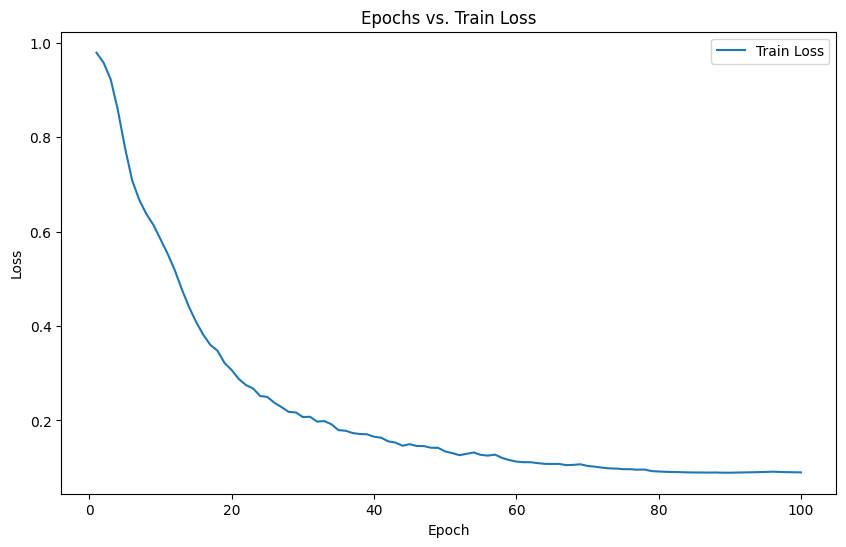

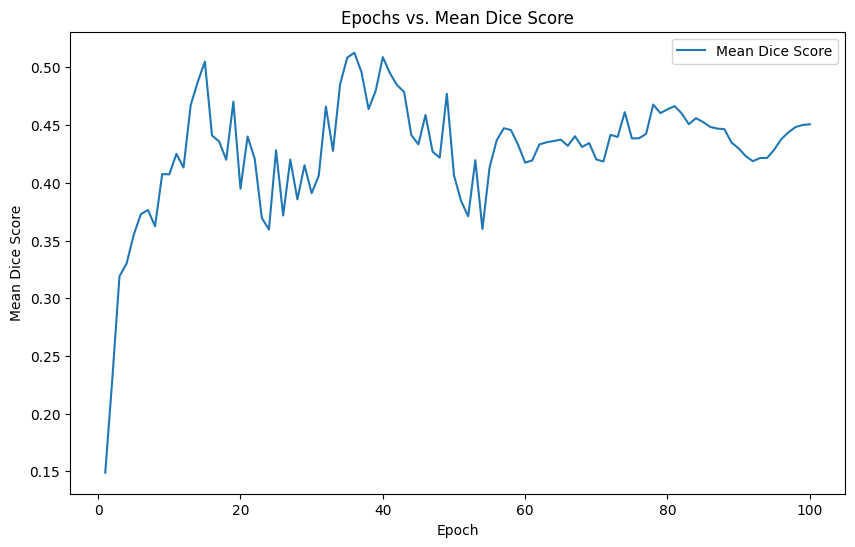

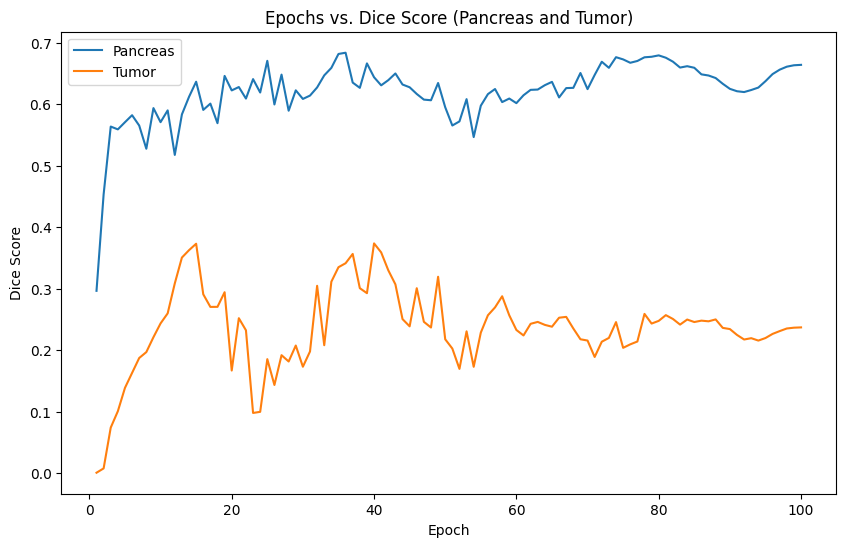

In [25]:
import matplotlib.pyplot as plt

# Plot epochs vs train loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_epochs + 1), epoch_loss_values, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epochs vs. Train Loss')
plt.legend()
plt.show()

# Plot epochs vs mean dice score
plt.figure(figsize=(10, 6))
plt.plot(range(val_interval, max_epochs + 1, val_interval), metric_values, label='Mean Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Mean Dice Score')
plt.title('Epochs vs. Mean Dice Score')
plt.legend()
plt.show()

# Plot epochs vs class 1, 2, and 3 dice scores
plt.figure(figsize=(10, 6))
plt.plot(range(val_interval, max_epochs + 1, val_interval), metric_values_class1, label='Pancreas')
plt.plot(range(val_interval, max_epochs + 1, val_interval), metric_values_class2, label='Tumor')

plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Epochs vs. Dice Score (Pancreas and Tumor)')
plt.legend()
plt.show()


In [ ]:
model.eval()  # Set the model in evaluation mode
with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        val_outputs = inference(val_inputs)  # Perform inference on validation data
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        
        # Convert the predictions to binary labels
        pred_labels_class1 = torch.argmax(val_outputs[0], dim=1)  # Predicted labels for class 1
        pred_labels_class2 = torch.argmax(val_outputs[1], dim=1)  # Predicted labels for class 2
        
        # Calculate the overlapping pixels between the predicted labels for class 1 and class 2
        overlapping_pixels = torch.sum(pred_labels_class1 & pred_labels_class2).item()
        total_pixels = pred_labels_class1.numel()  # Total number of pixels
        
        overlap_percentage = (overlapping_pixels / total_pixels) * 100
        
        print(f"Overlap percentage between class 1 and class 2: {overlap_percentage:.2f}%")


IndexError: list index out of range

In [6]:
model_dir = "/home/model_codes/"
model=(torch.load(
    os.path.join(model_dir, "best_metric_model_diceceloss.pth")))

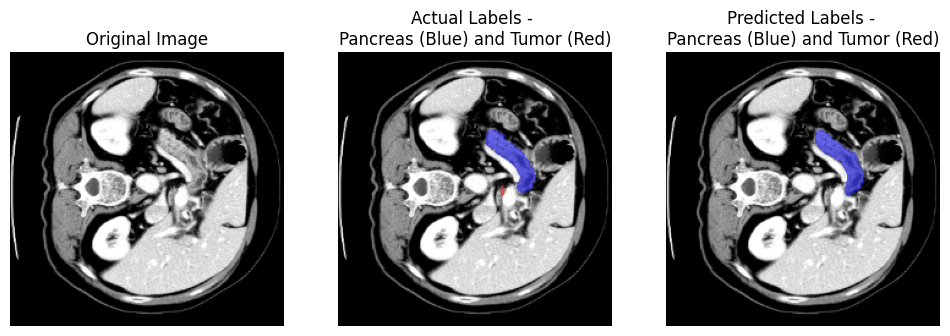

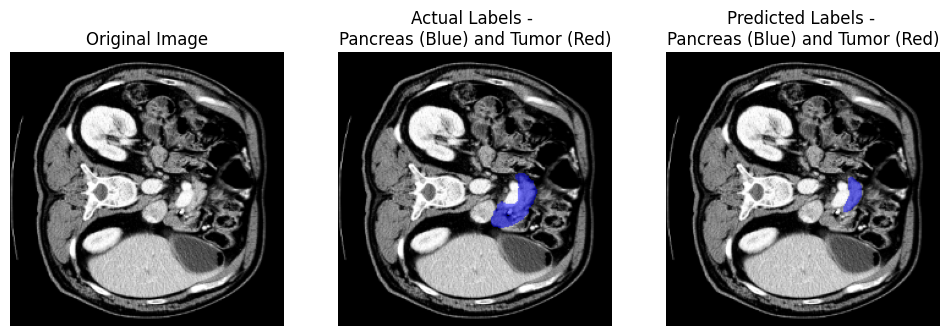

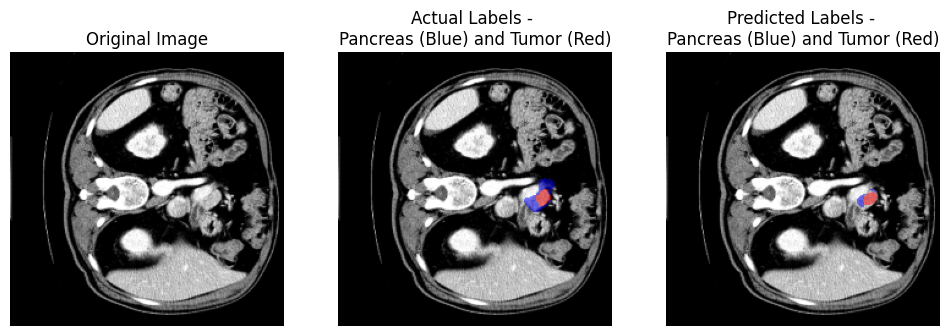

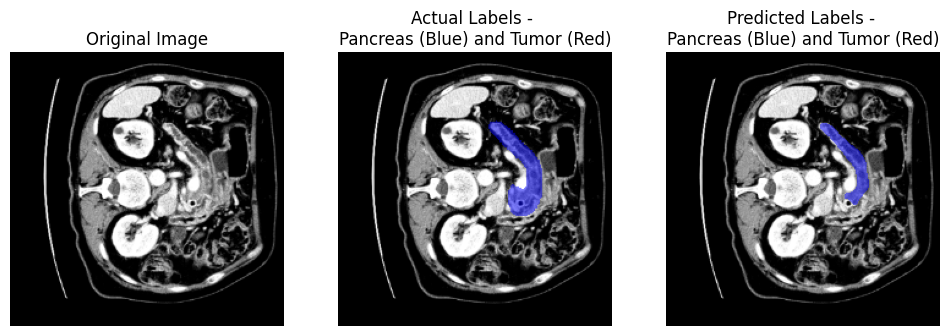

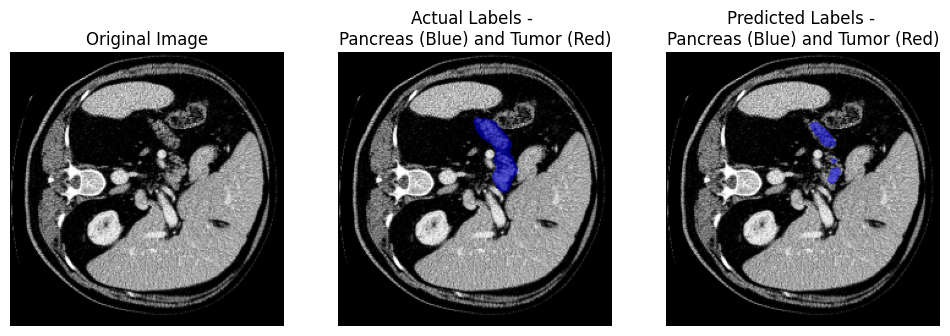

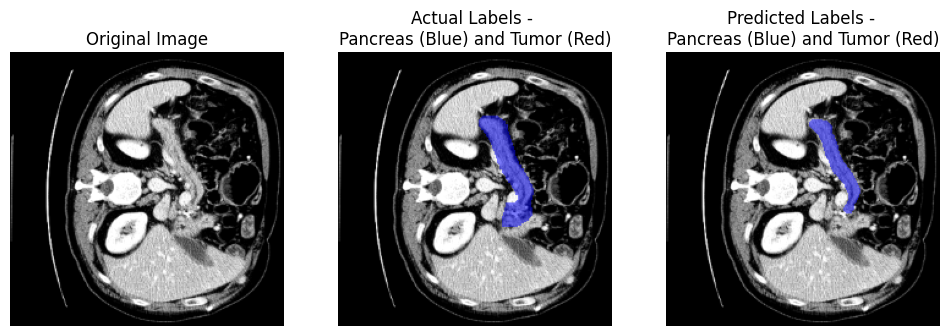

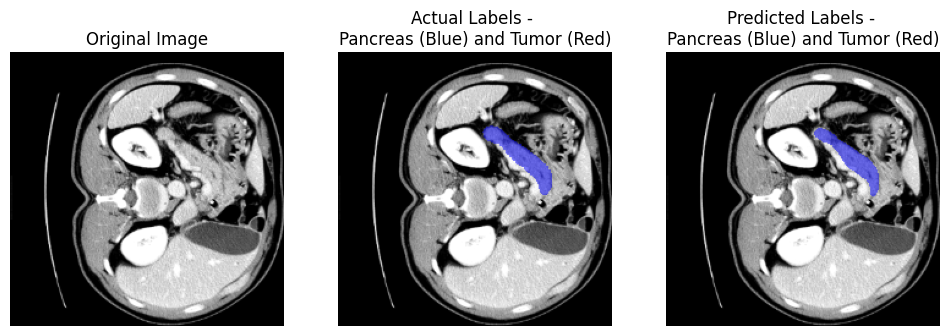

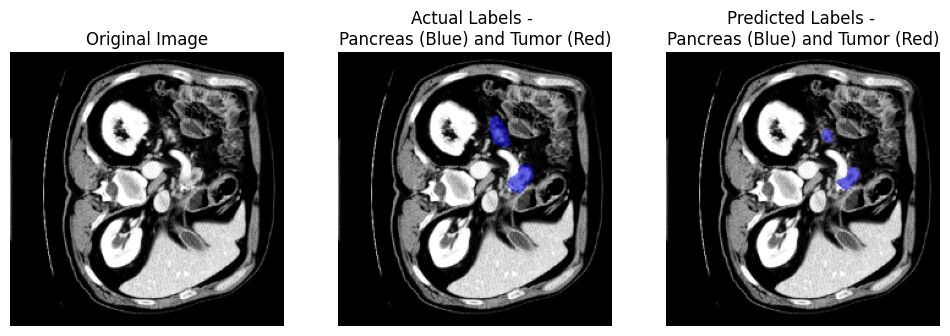

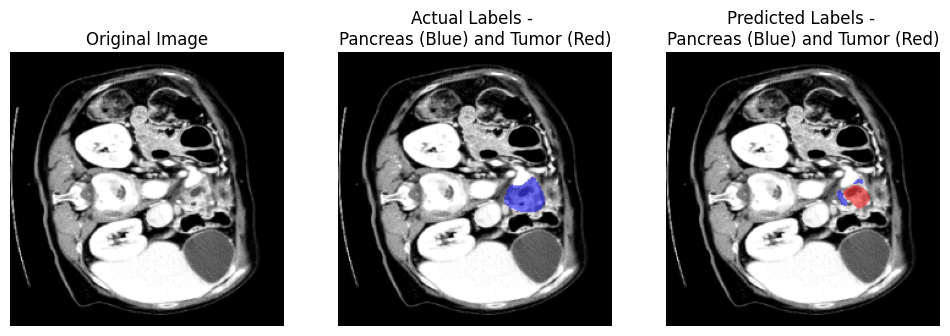

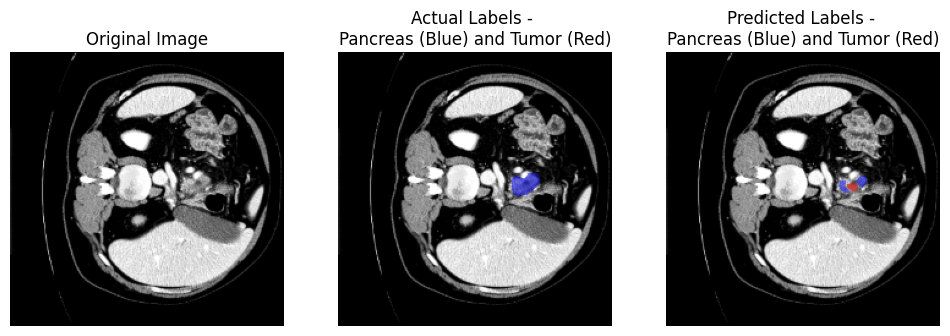

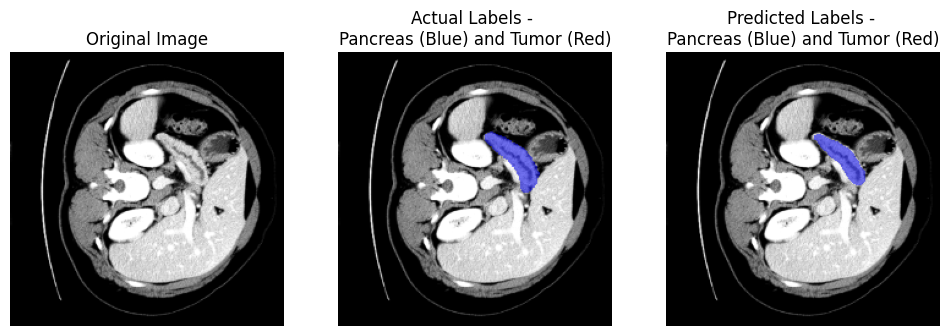

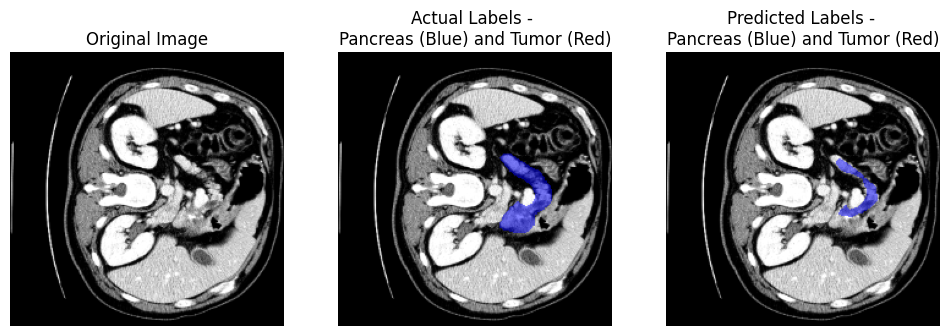

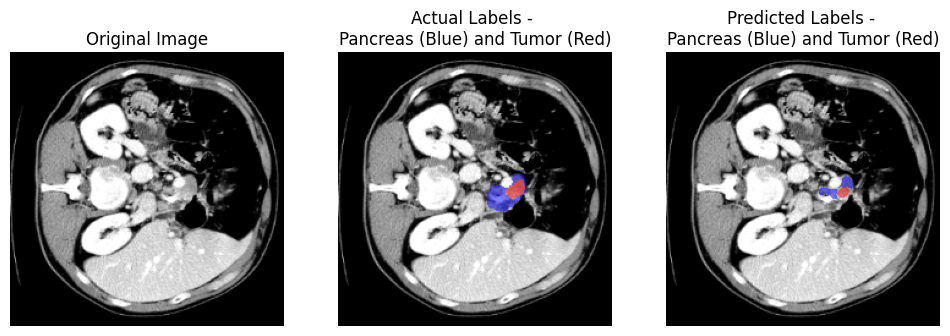

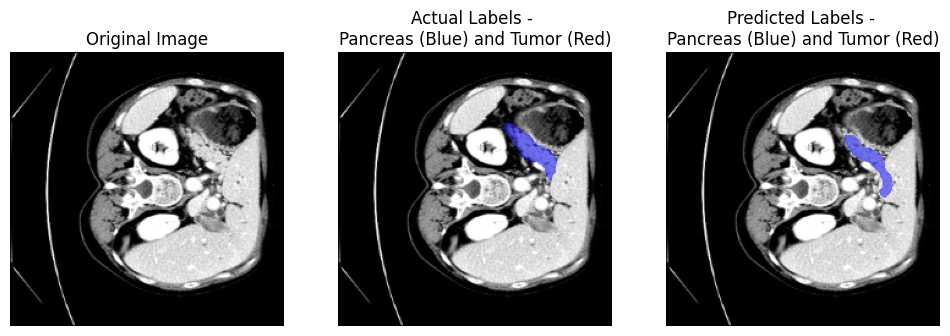

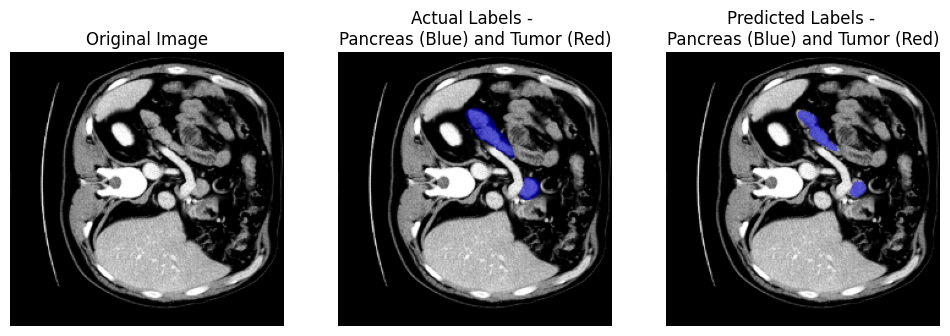

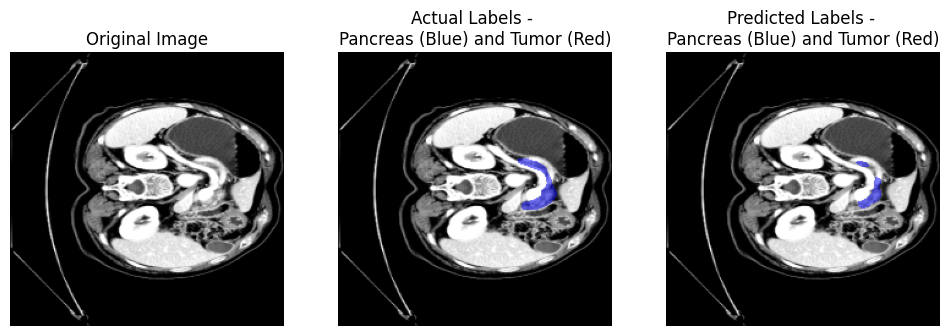

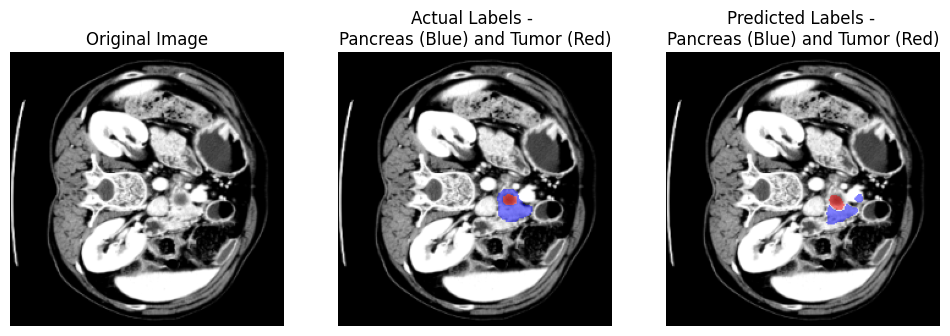

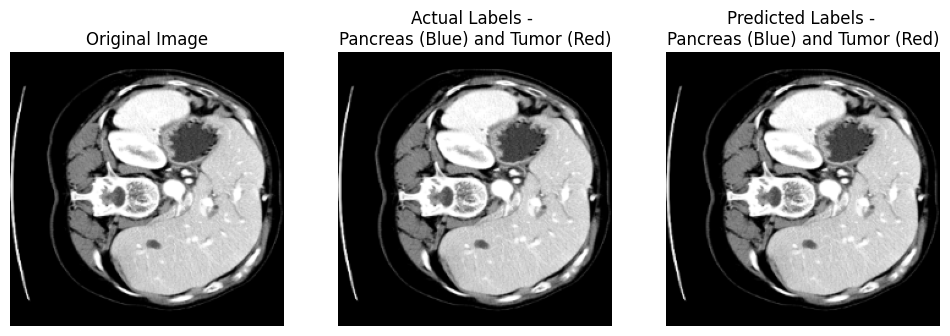

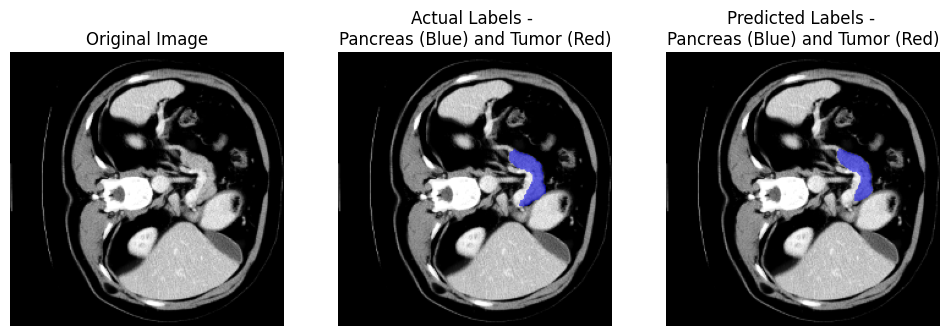

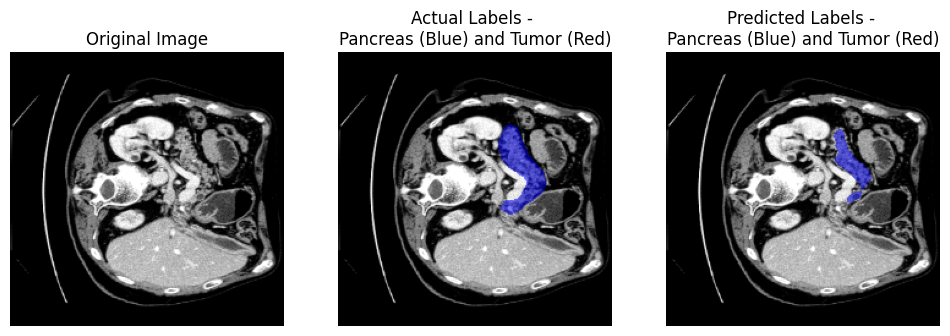

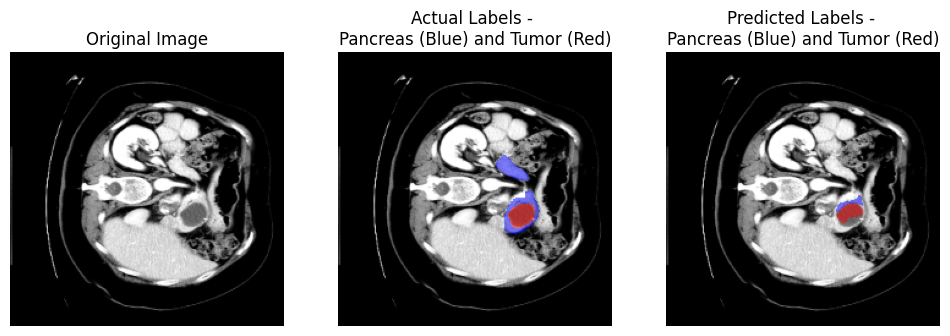

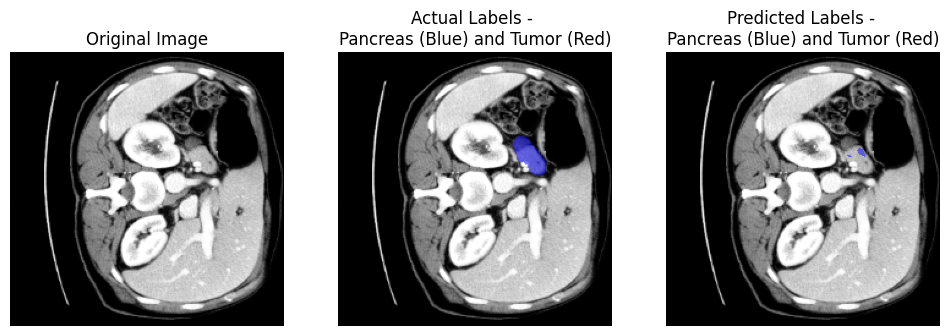

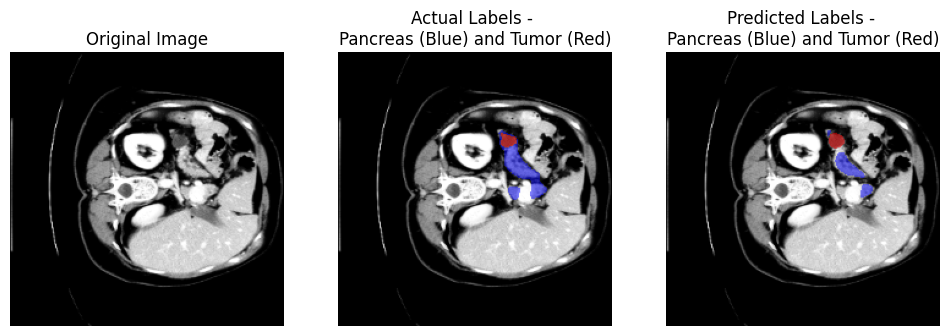

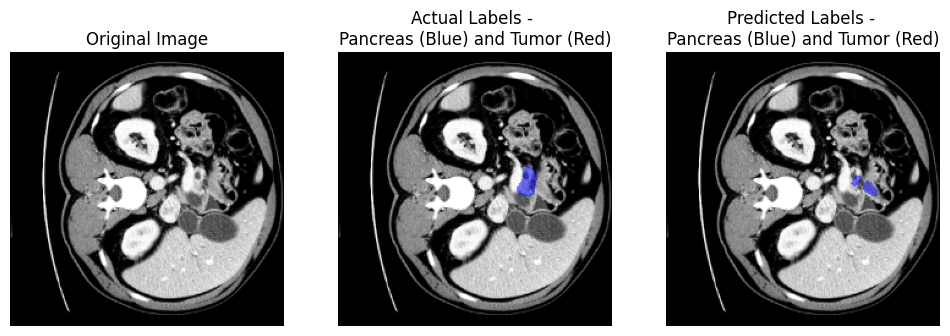

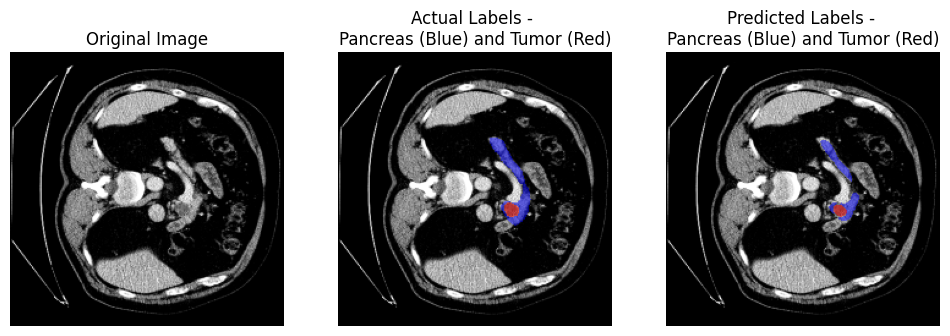

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Set the model to evaluation mode
model.eval()

# Create a colormap for the blue label
colors = [(0, 0, 1, i) for i in np.linspace(0, 1, 100)]
blue_cmap = mcolors.LinearSegmentedColormap.from_list('blue_alpha', colors)

# Create a colormap for the red label
colors = [(1, 0, 0, i) for i in np.linspace(0, 1, 100)]
red_cmap = mcolors.LinearSegmentedColormap.from_list('red_alpha', colors)

# Create empty lists to store the original image, model prediction, and actual labels
original_images = []
model_predictions = []
actual_labels = []

# Iterate over the validation dataset
with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        
        # Forward pass through the model to obtain the predictions
        val_outputs = model(val_inputs)
        
        # Convert the predicted outputs and actual labels to numpy arrays
        val_outputs = val_outputs.cpu().numpy()
        val_labels = val_labels.cpu().numpy()
        
        # Append the original image, model prediction, and actual labels to the respective lists
        original_images.append(val_inputs.cpu().numpy())
        model_predictions.append(val_outputs)
        actual_labels.append(val_labels)

# Convert the lists to numpy arrays
original_images = np.concatenate(original_images, axis=0)
model_predictions = np.concatenate(model_predictions, axis=0)
actual_labels = np.concatenate(actual_labels, axis=0)

# Apply threshold to model predictions
threshold = 0.5
model_predictions = np.where(model_predictions >= threshold, 1, 0)

# Iterate over the last 10 images in the validation set and visualize the original image, model prediction, and actual labels
for i in range(len(original_images)):
    plt.figure(figsize=(12, 4))
    
    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_images[i, 0, :, :, 72], cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    # Plot the image with actual labels (pancreas in blue, tumor in red)
    plt.subplot(1, 3, 2)
    plt.imshow(original_images[i, 0, :, :, 72], cmap='gray')
    plt.imshow(actual_labels[i, 0, :, :, 72], cmap=blue_cmap, alpha=0.5)
    plt.imshow(actual_labels[i, 1, :, :, 72], cmap=red_cmap, alpha=0.5)
    plt.title("Actual Labels - \nPancreas (Blue) and Tumor (Red)")
    plt.axis('off')
    
    # Plot the image with predicted labels (pancreas in blue, tumor in red)
    plt.subplot(1, 3, 3)
    plt.imshow(original_images[i, 0, :, :, 72], cmap='gray')
    plt.imshow(model_predictions[i, 0, :, :, 72], cmap=blue_cmap, alpha=0.5)
    plt.imshow(model_predictions[i, 1, :, :, 72], cmap=red_cmap, alpha=0.5)
    plt.title("Predicted Labels - \nPancreas (Blue) and Tumor (Red)")
    plt.axis('off')
    
    plt.show()


In [ ]:
d = 68
c1 = model_predictions[0, 0, :, :, d]
c2 = model_predictions[0, 1, :, :, d]

In [ ]:
((c1 + c2) == 2).sum()

3

In [ ]:
c3 = model_predictions[2, 0, :, :, d]
c4 = model_predictions[2, 1, :, :, d]
((c3 + c4) == 2).sum()

0

In [21]:
import matplotlib.pyplot as plt

# Iterate over the predicted labels
for i in range(model_predictions.shape[0]):
    label1 = model_predictions[i, 0, :, :, d]
    label2 = model_predictions[i, 1, :, :, d]
    
    # Calculate the overlap
    overlap = np.logical_and(label1, label2)

    # Count overlapping pixels
    num_overlapping_pixels = np.sum(overlap)
    print(f"Number of overlapping pixels: {num_overlapping_pixels}")

    if num_overlapping_pixels > 0:  # If there is any overlap
        # Create a figure and axes
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        # Show the two labels and their overlap
        ax[0].imshow(label1, cmap='gray')
        ax[0].set_title("Label 1")

        ax[1].imshow(label2, cmap='gray')
        ax[1].set_title("Label 2")

        ax[2].imshow(overlap, cmap='gray')
        ax[2].set_title("Overlap")

        # Display the figure
        plt.show()


NameError: name 'model_predictions' is not defined